# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60.0K/60.0K [04:24<00:00, 227File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

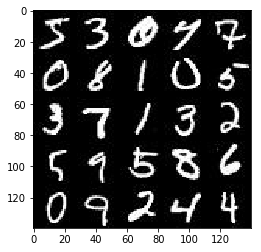

In [1]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

import helper
data_dir = './data'

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

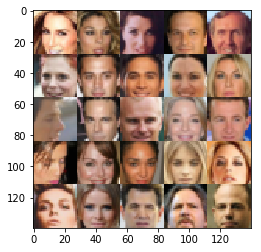

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0


c:\users\lai\anaconda3\envs\face_generation\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z, tf.placeholder(tf.float32, [], name='learning_rate')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 32x32x3
            x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            relu1 = tf.maximum(alpha * x1, x1)
            # 16x16x64

            x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * bn2, bn2)
            # 8x8x128

            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)
            # 4x4x256

            # Flatten it
            flat = tf.reshape(relu3, (-1, 4*4*256))
            logits = tf.layers.dense(flat, 1)
            logits = tf.layers.dropout(logits, rate=0.3)
            out = tf.sigmoid(logits)

            return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.random_uniform(tf.shape(d_model_real), minval=0.7, maxval=1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.random_uniform(tf.shape(d_model_fake), minval=0.0, maxval=0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.random_uniform(tf.shape(d_model_fake), minval=0.7, maxval=1.2)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`


Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
%matplotlib inline

import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
 
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
  
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

class GAN:
    def __init__(self, real_size, z_size, beta1=0.5):
        weight = real_size[1]
        height = real_size[2]
        channel = real_size[3]
        self.input_real, self.input_z, self.learning_rate = model_inputs(weight, height, channel, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              channel)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    steps = 0
    z_size = z_dim
    print_every=10
    show_every=100 
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    net = GAN(data_shape, z_size, beta1=beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate:learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs), "Discriminator Loss: {:.4f}...".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 0.6276... Generator Loss: 1.6101
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 1.0248... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.8702... Generator Loss: 0.3778
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.5770


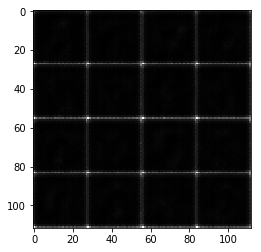

Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.4145
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.8380
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.6158


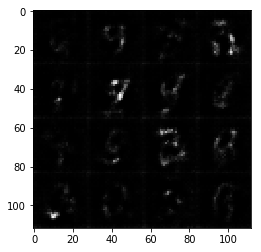

Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.4122
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.7133


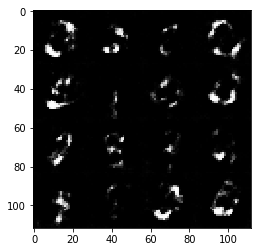

Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.9598
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.4820
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 0.6620
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 1.1487


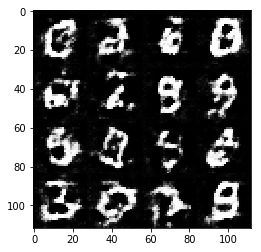

Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.1116
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.5258


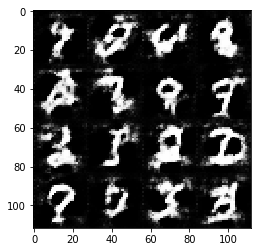

Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.7677
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.4134
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.9635
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 0.6609


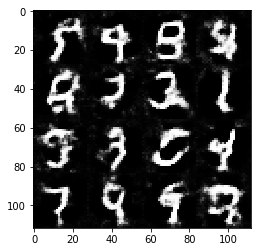

Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.4833
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.4104
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 0.6497


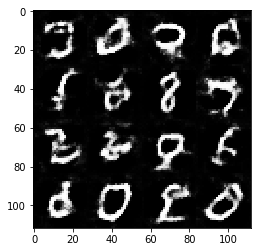

Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 0.5058
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.6673
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 1.1145


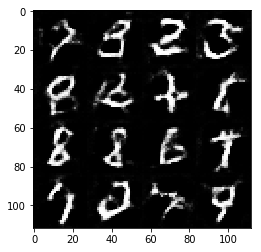

Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 0.5714
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.5880
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.8348
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.9293


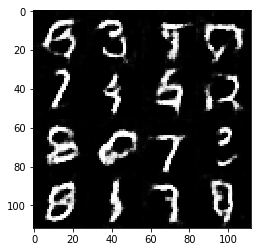

Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 0.9642
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.8621


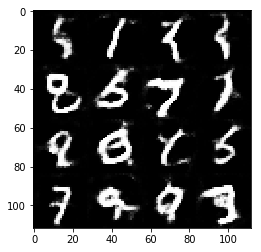

Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 1.0463


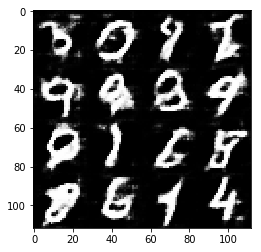

Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.5919
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.6323
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.6236
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.6391


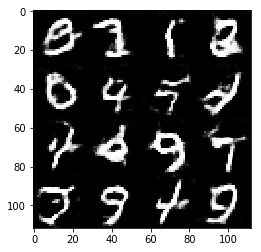

Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.5678
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.4298
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.5199
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 0.9081


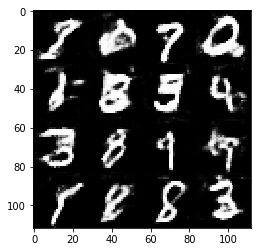

Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.7128
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.5795


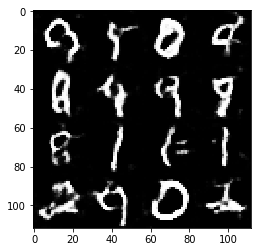

Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.7835
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.4155
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.0938... Generator Loss: 0.7763


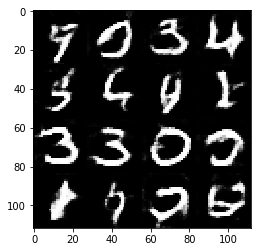

Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.4862
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.4392
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.7147


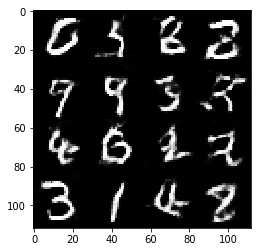

Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.5434
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.5448
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.6213
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.5325
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 0.9063


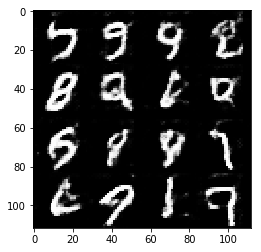

Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.8115
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.6141
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 0.5434
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 1.2462


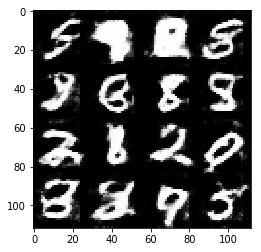

Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.6105
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.6088
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.4871
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.7579


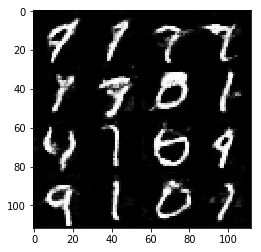

Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.6229
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.0988
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.5351
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.7835
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 0.5531
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.6005
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.9077


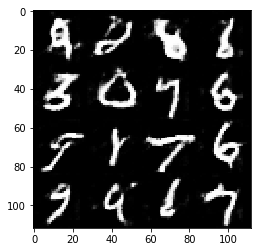

Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.7189


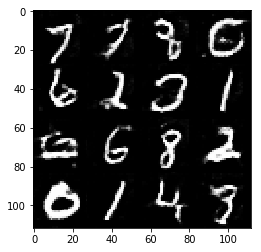

Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.5999
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 0.9091
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.7376
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.6318
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.5160
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 0.8035


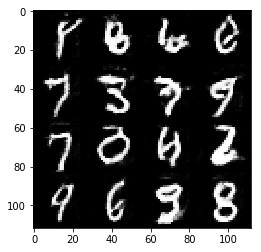

Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.8650
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.6285


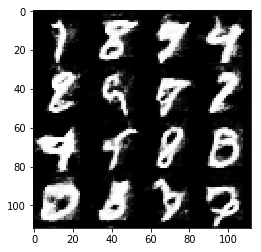

Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.3928
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.5904
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.7392


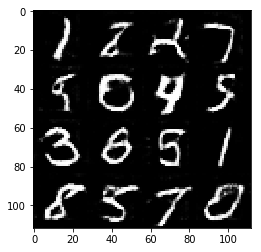

In [24]:
batch_size = 50
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 2.3473
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.9981


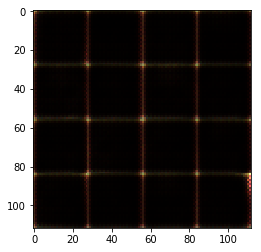

Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.5032


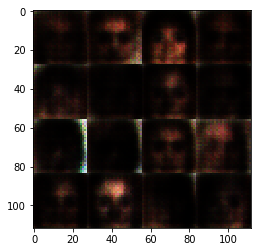

Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.9505
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 2.0085
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6798


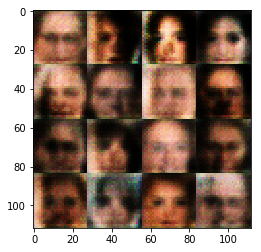

Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.7379... Generator Loss: 0.3693
Epoch 1/1... Discriminator Loss: 2.2605... Generator Loss: 0.2251
Epoch 1/1... Discriminator Loss: 2.1136... Generator Loss: 0.2705
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8278


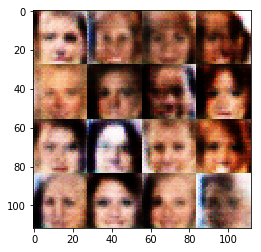

Epoch 1/1... Discriminator Loss: 1.8702... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.3141
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 2.2245
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.4842


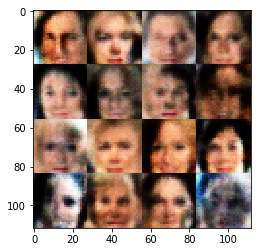

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.1558
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.6596


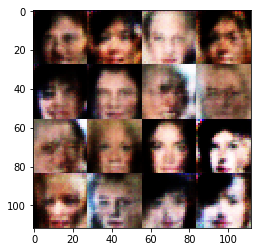

Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.4125
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4379


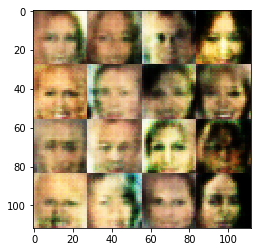

Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.3117
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7098


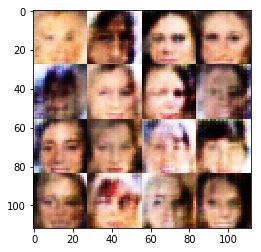

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7785


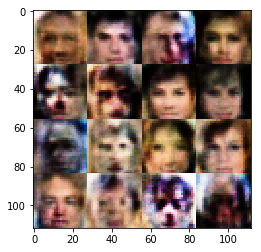

Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.9452
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.9929


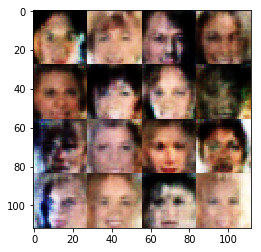

Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.4227
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 2.1799... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.5893


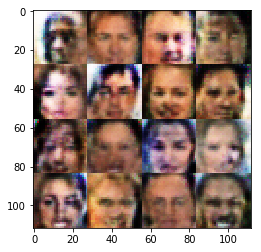

Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7219


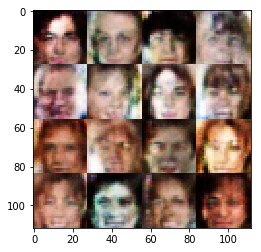

Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 1.6103
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.2472


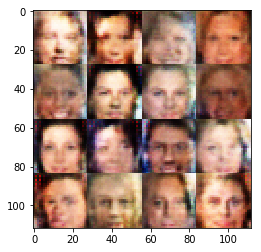

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 0.9589


In [25]:
batch_size = 150
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.